In [50]:
### IMPORTS ###
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets

In [49]:
### SETTINGS ###
np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

plt.rcParams['text.usetex'] = True

In [52]:
### FOLDER SETTINGS ###
input_folder = "../output/"

file_solution_path = input_folder + "/system_solution.dat"  # Replace with your actual file path
rhs_path = input_folder + "/system_rhs.dat"  # Replace with your actual file path
residual_path = input_folder + "/system_residual.dat"  # Replace with your actual file path

In [51]:
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian

In [53]:
### Analytical solution functions ###

# This function creates a ND numpy array
def np_u_analytical_poisson(ndims, global_domain_begin, global_domain_end, grid_size, t):
    # Create coordinate arrays for each dimension
    p_coords = [np.linspace(global_domain_begin[i], global_domain_end[i], grid_size[i]) for i in range(ndims)]
    
    # Generate meshgrid from coordinate arrays
    meshgrid = np.meshgrid(*p_coords, indexing='ij')
    
    # Compute function values
    #func_val = np.prod(np.sin(np.pi * np.stack(meshgrid)),axis=0)
    #func_val = (np.sin(np.pi * meshgrid[1]) * np.sin(2 * np.pi * meshgrid[0]) + meshgrid[1] * np.sin(np.pi * meshgrid[0])) * np.cos(t)
    func_val = np.exp(t)*np.sin(meshgrid[1]) * np.sin(meshgrid[0])
    
    return func_val, meshgrid, p_coords

In [54]:
### PLOTTING FUNCTIONS ###

# ALWAYS 2D
def plot_imshow(extent, true_solution, approximate_solution, rhs, residual):
    error = np.abs(approximate_solution - true_solution)
    l2_error = np.linalg.norm(approximate_solution - true_solution, 2)
    residual_error = np.abs(residual)
    residual_l2_error = np.linalg.norm(residual, 2)
    print(f"Solution: Max error: {np.max(error):.1e}, L2-error: {l2_error:.1e}")
    print(f"Residual: Max error: {np.max(residual_error):.1e}, L2-error: {residual_l2_error:.1e}")

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    # True solution plot
    cax1 = axes[0,0].imshow(true_solution, extent=extent, cmap='viridis', aspect='auto', origin='lower')
    axes[0,0].set_title('True Solution')
    fig.colorbar(cax1, ax=axes[0,0], orientation='vertical')

    # Approximate solution plot
    cax2 = axes[0,1].imshow(approximate_solution, extent=extent, cmap='viridis', aspect='auto', origin='lower')
    axes[0,1].set_title('Approximate Solution')
    fig.colorbar(cax2, ax=axes[0,1], orientation='vertical')

    # Error plot
    cax3 = axes[0,2].imshow(error, extent=extent, cmap='hot', aspect='auto', origin='lower')
    axes[0,2].set_title('Solution Error')
    fig.colorbar(cax3, ax=axes[0,2], orientation='vertical')

    # RHS plot
    cax4 = axes[1,0].imshow(rhs, extent=extent, cmap='viridis', aspect='auto', origin='lower')
    axes[1,0].set_title('RHS')
    fig.colorbar(cax4, ax=axes[1,0], orientation='vertical')

    # Residual plot
    cax5 = axes[1,1].imshow(residual, extent=extent, cmap='viridis', aspect='auto', origin='lower')    
    axes[1,1].set_title('Residual')
    fig.colorbar(cax5, ax=axes[1,1], orientation='vertical')

    # Residual error plot
    cax6 = axes[1,2].imshow(residual_error, extent=extent, cmap='hot', aspect='auto', origin='lower')
    axes[1,2].set_title('Residual Error')
    fig.colorbar(cax6, ax=axes[1,2], orientation='vertical')
    
    plt.tight_layout()
    plt.show()

    return

def save_plots(true_solution, approximate_solution, error, residual, extent):
    # True solution plot
    plt.figure(figsize=(8, 6))
    plt.imshow(true_solution, extent=extent, cmap='viridis', aspect='auto', origin='lower')
    plt.title('True Solution')
    plt.colorbar(orientation='vertical')
    plt.savefig('true_solution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Approximate solution plot
    plt.figure(figsize=(8, 6))
    plt.imshow(approximate_solution, extent=extent, cmap='viridis', aspect='auto', origin='lower')
    plt.title('Approximate Solution')
    plt.colorbar(orientation='vertical')
    plt.savefig('approximate_solution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Error plot
    plt.figure(figsize=(8, 6))
    plt.imshow(error, extent=extent, cmap='hot', aspect='auto', origin='lower')
    plt.title('Solution Error')
    plt.colorbar(orientation='vertical')
    plt.savefig('error.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Residual plot
    plt.figure(figsize=(8, 6))
    plt.imshow(residual, extent=extent, cmap='viridis', aspect='auto', origin='lower')
    plt.title('Residual')
    plt.colorbar(orientation='vertical')
    plt.savefig('residual.png', dpi=300, bbox_inches='tight'),
    plt.close()

    return

In [55]:
data = np.fromfile(file_solution_path, dtype=np.float64)
approximate_solution = np.array(data)

data = np.fromfile(rhs_path, dtype=np.float64)
rhs = np.array(data)

data = np.fromfile(residual_path, dtype=np.float64)
residual = np.array(data)

In [56]:
ndims = 2
num_data_per_elements = 1
grid_size = [2048,2048]

layout = (grid_size[0], grid_size[1], num_data_per_elements)

print("Layout: ", layout)

Layout:  (2048, 2048, 1)


In [57]:
# Reshape the data into a 2D array
approximate_solution = np.array(approximate_solution)
rhs = np.array(rhs)
residual = np.array(residual)

approximate_solution = approximate_solution.reshape(layout)
rhs = rhs.reshape(layout)
residual = residual.reshape(layout)

approximate_solution = np.squeeze(approximate_solution)
rhs = np.squeeze(rhs)
residual = np.squeeze(residual)
print(approximate_solution.shape)

(2048, 2048)


In [58]:
domain_begin_array = np.full(ndims, -10*np.pi)
domain_end_array = np.full(ndims, 10*np.pi)
t = 1.0
true_solution, mesh, p_coords = np_u_analytical_poisson(ndims, domain_begin_array, domain_end_array, layout, t)

Solution: Max error: 2.4e-02, L2-error: 3.5e+00
Residual: Max error: 4.6e+00, L2-error: 2.3e+02


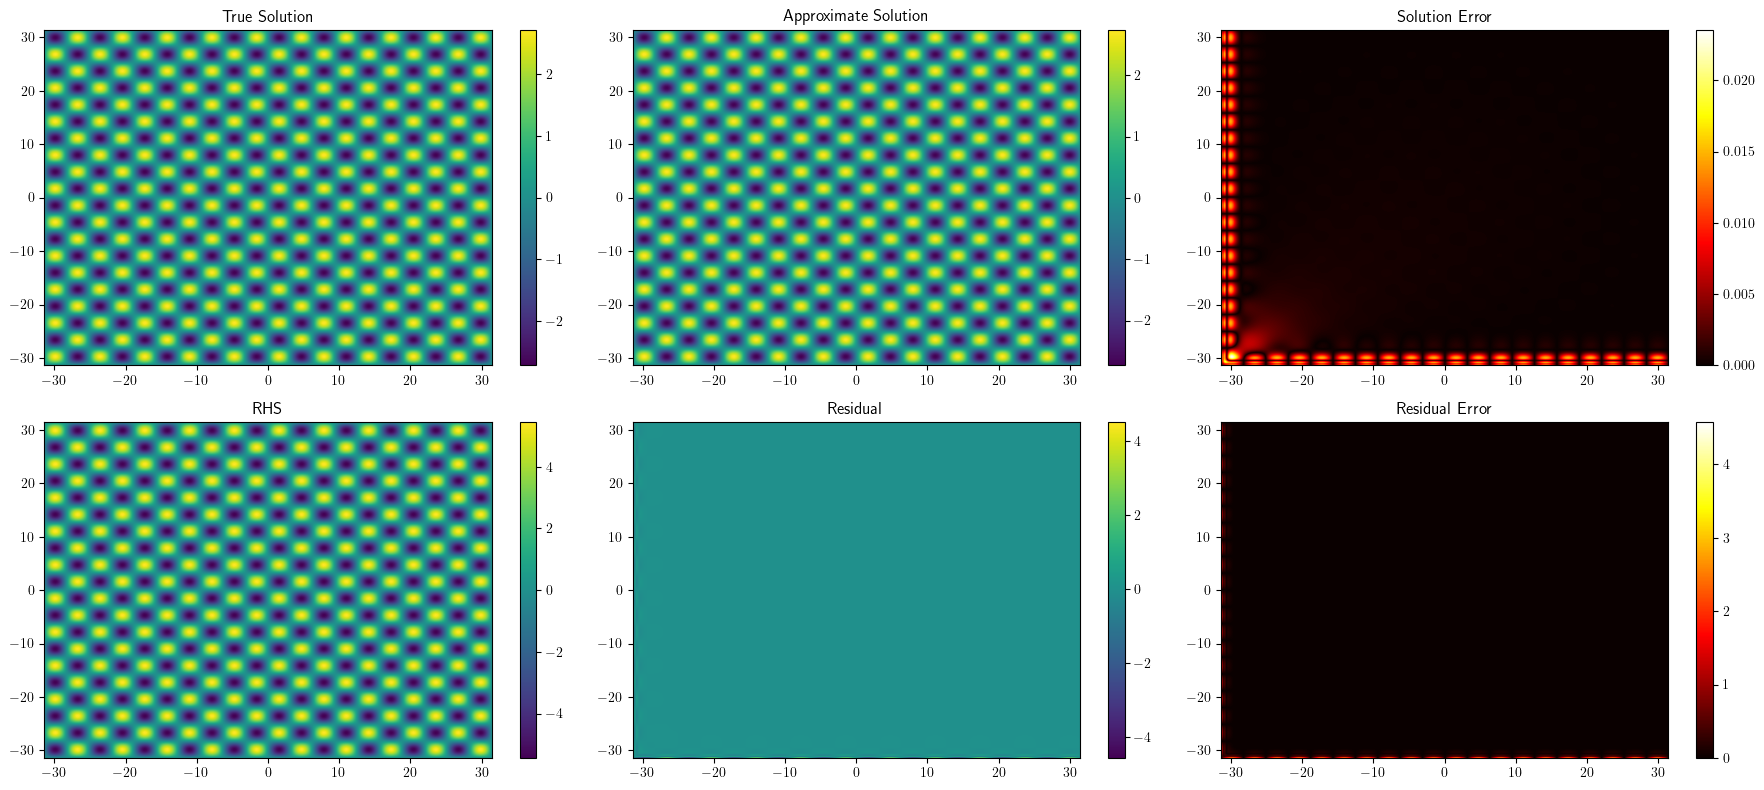

In [59]:
plot_imshow([domain_begin_array[0],domain_end_array[0], domain_begin_array[1], domain_end_array[1]],true_solution, approximate_solution, rhs, residual)
save_plots(true_solution, approximate_solution, np.abs(approximate_solution - true_solution), residual, [domain_begin_array[0],domain_end_array[0], domain_begin_array[1], domain_end_array[1]])

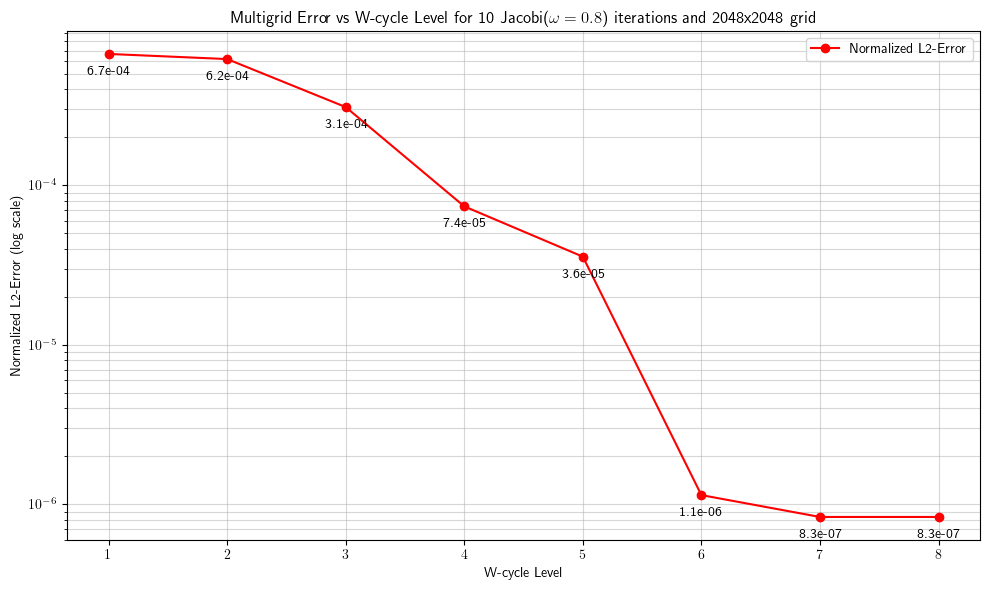

In [62]:
# Step 1: Prepare the data
w_cycle_levels = [1, 2, 3, 4, 5, 6, 7, 8]
l2_errors = [2.8e+03, 2.6e+03, 1.3e+03, 3.1e+02, 1.5e+02, 4.8e+00, 3.5e+00, 3.5e+00]

# Normalize the L2 errors by the number of points
l2_errors = [(l2_err/(2048*2048)) for l2_err in l2_errors]

#print(l2_errors)

# Step 2: Create the plot
plt.figure(figsize=(10, 6))

# Step 3: Plot L2 Error
plt.semilogy(w_cycle_levels, l2_errors, 'ro-', label='Normalized L2-Error')

# Step 4: Customize the plot
plt.xlabel('W-cycle Level')
plt.ylabel('Normalized L2-Error (log scale)')
plt.title(r'Multigrid Error vs W-cycle Level for 10 Jacobi($\omega=0.8$) iterations and 2048x2048 grid')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

# Step 5: Add annotations for each point
for i, (l2_err) in enumerate(l2_errors):
    plt.annotate(f'{l2_err:.1e}', (w_cycle_levels[i], l2_err), textcoords="offset points", xytext=(0,-15), ha='center')

# Step 6: Show the plot
plt.tight_layout()

# Step 7: Save the plot
plt.savefig('multigrid_error_vs_w_cycle_level.png', dpi=300)

plt.show()

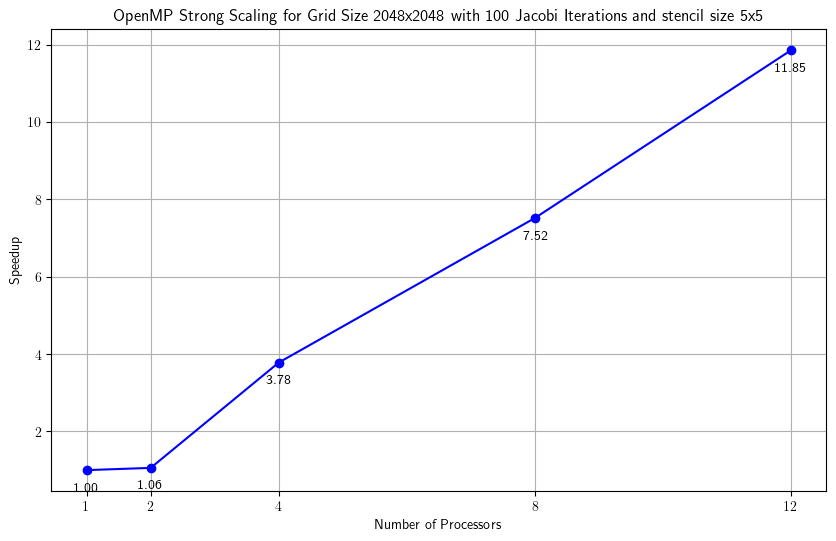

In [61]:
# OpenMP strong scaling plot for a grid of size 2048x2048 and a 100 Jacobi iterations
processors = [1, 2, 4, 8, 12] # Number of processors
wall_time = [55.955, 52.893, 14.802, 7.444, 4.720] # In seconds

# Calculate the speedup
speedup = [wall_time[0] / t for t in wall_time]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(processors, speedup, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('OpenMP Strong Scaling for Grid Size 2048x2048 with 100 Jacobi Iterations and stencil size 5x5')
plt.xlabel('Number of Processors')
plt.ylabel('Speedup')
plt.xticks(processors)
plt.grid(True)

# Annotate the points
for i, txt in enumerate(speedup):
    plt.annotate(f'{txt:.2f}', (processors[i], speedup[i]), textcoords="offset points", xytext=(0,-15), ha='center')

# Save the plot
plt.savefig('openmp_strong_scaling.png', dpi=300)

# Display the plot
plt.show()

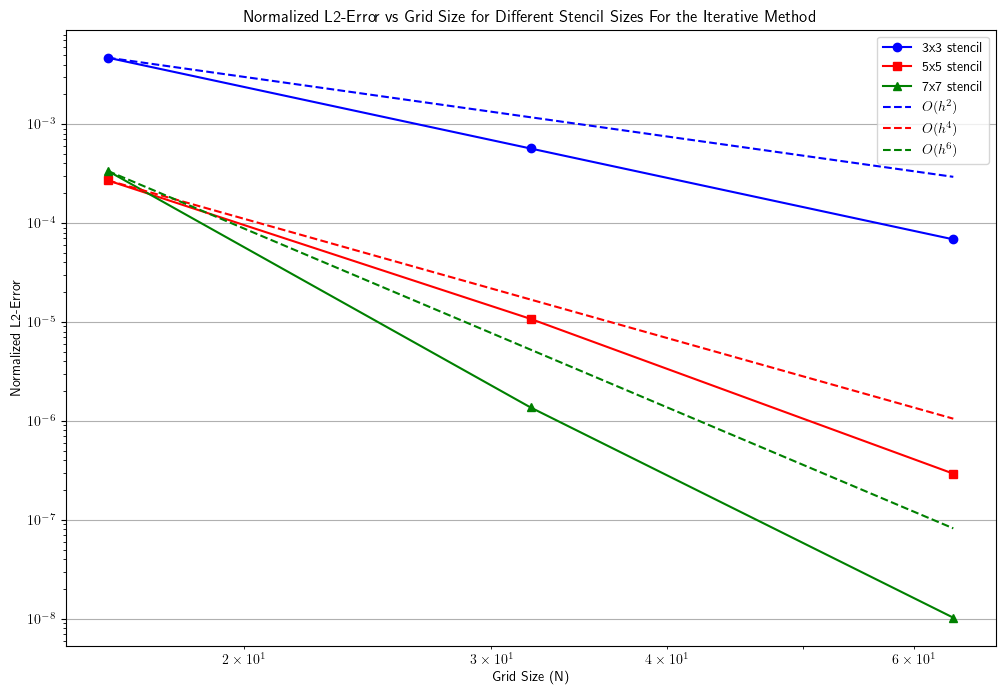

In [60]:
######################## CONVERGENCE PLOT FOR THE ITERATIVE METHOD ############################

# Step 1: Prepare the data
grid_sizes = [16, 32, 64] * 3
stencil_sizes = ['3x3'] * 3 + ['5x5'] * 3 + ['7x7'] * 3
l2_errors = [1.2e+00, 5.8e-01, 2.8e-01,
             6.9e-02, 1.1e-02, 1.2e-03,
             8.6e-02, 1.4e-03, 4.2e-05]

# Normalize the L2 errors by the number of points
l2_errors = [err / (N**2) for err, N in zip(l2_errors, grid_sizes)]

# Step 2: Create arrays for each stencil size (same as before)
grid_3x3 = np.array(grid_sizes[:3])
grid_5x5 = np.array(grid_sizes[3:6])
grid_7x7 = np.array(grid_sizes[6:])

# For L2 errors
error_3x3 = np.array(l2_errors[:3])
error_5x5 = np.array(l2_errors[3:6])
error_7x7 = np.array(l2_errors[6:])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))
plt.loglog(grid_3x3, error_3x3, 'bo-', label='3x3 stencil')
plt.loglog(grid_5x5, error_5x5, 'rs-', label='5x5 stencil')
plt.loglog(grid_7x7, error_7x7, 'g^-', label='7x7 stencil')

# Step 4: Add convergence lines
grid_range = np.logspace(np.log10(grid_sizes[0]), np.log10(grid_sizes[-1]), 100)
h = 1 / grid_range

# O(h^2) convergence line
c2 = error_3x3[0] * (grid_sizes[0]**2)  # Constant to match the first point of 3x3 stencil
plt.loglog(grid_range, c2 * h**2, 'b--', label='$O(h^2)$')

# O(h^6) convergence line
c4 = error_5x5[0] * (grid_sizes[0]**4)  # Constant to match the first point of 5x5 stencil
plt.loglog(grid_range, c4 * h**4, 'r--', label='$O(h^4)$')

# O(h^8) convergence line
c6 = error_7x7[0] * (grid_sizes[0]**6)  # Constant to match the first point of 7x7 stencil
plt.loglog(grid_range, c6 * h**6, 'g--', label='$O(h^6)$')

# Step 5: Add labels and title
plt.xlabel('Grid Size (N)')
plt.ylabel('Normalized L2-Error')
plt.title('Normalized L2-Error vs Grid Size for Different Stencil Sizes For the Iterative Method')
plt.legend()
plt.grid(True)

# Step 6: Save the plot
plt.savefig('convergence_plot_iterative_method.png', dpi=300)

# Step 6: Show the plot
plt.show()

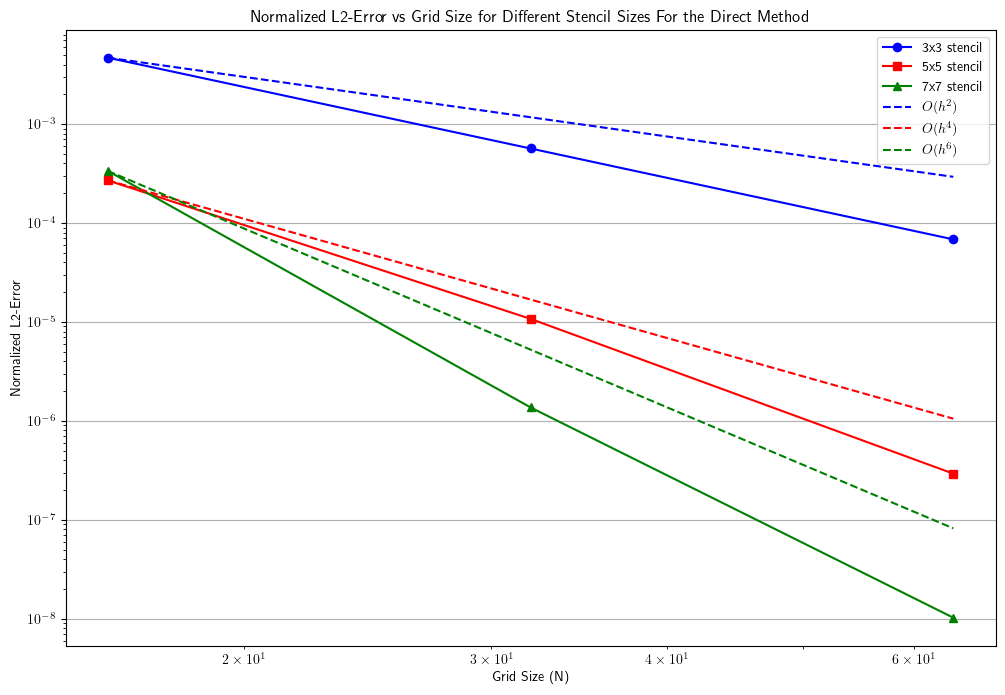

In [63]:
######################## CONVERGENCE PLOT FOR THE DIRECT METHOD ############################

# Step 1: Prepare the data
grid_sizes = [16, 32, 64] * 3
stencil_sizes = ['3x3'] * 3 + ['5x5'] * 3 + ['7x7'] * 3
l2_errors = [1.2e+00, 5.8e-01, 2.8e-01,
             6.9e-02, 1.1e-02, 1.2e-03,
             8.6e-02, 1.4e-03, 4.2e-05]

# Normalize the L2 errors by the number of points
l2_errors = [err / (N**2) for err, N in zip(l2_errors, grid_sizes)]

# Step 2: Create arrays for each stencil size
grid_3x3 = np.array(grid_sizes[:3])
grid_5x5 = np.array(grid_sizes[3:6])
grid_7x7 = np.array(grid_sizes[6:])

# For L2 errors
error_3x3 = np.array(l2_errors[:3])
error_5x5 = np.array(l2_errors[3:6])
error_7x7 = np.array(l2_errors[6:])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))
plt.loglog(grid_3x3, error_3x3, 'bo-', label='3x3 stencil')
plt.loglog(grid_5x5, error_5x5, 'rs-', label='5x5 stencil')
plt.loglog(grid_7x7, error_7x7, 'g^-', label='7x7 stencil')

# Step 4: Add convergence lines
grid_range = np.logspace(np.log10(grid_sizes[0]), np.log10(grid_sizes[-1]), 100)
h = 1 / grid_range

# O(h^2) convergence line
c2 = error_3x3[0] * (grid_sizes[0]**2)  # Constant to match the first point of 3x3 stencil
plt.loglog(grid_range, c2 * h**2, 'b--', label='$O(h^2)$')

# O(h^4) convergence line
c4 = error_5x5[0] * (grid_sizes[0]**4)  # Constant to match the first point of 5x5 stencil
plt.loglog(grid_range, c4 * h**4, 'r--', label='$O(h^4)$')

# O(h^6) convergence line
c6 = error_7x7[0] * (grid_sizes[0]**6)  # Constant to match the first point of 7x7 stencil
plt.loglog(grid_range, c6 * h**6, 'g--', label='$O(h^6)$')

# Step 5: Add labels and title
plt.xlabel('Grid Size (N)')
plt.ylabel('Normalized L2-Error')
plt.title('Normalized L2-Error vs Grid Size for Different Stencil Sizes For the Direct Method')
plt.legend()
plt.grid(True)

# Step 6: Save the plot
plt.savefig('direct_method_convergence_plot.png', dpi=300)

# Step 6: Show the plot
plt.show()